In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tram_pred import make_single_number
import numpy as np
from collections import deque
from tram_pred import prepare_file
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from cust_roc_score import cust_roc_score, multi_class_scorer
from pickle import Pickler, Unpickler

import os

In [3]:
tram_types = ["1_New", "2_CKD_Long", "3_CKD_Short", "4_Old"]
acc_types = ["accelerating", "braking"]
all_types = acc_types + ["negative"]

In [4]:
source_path = "c:/_Projects/sounds_tram/data/dataset"
target_path = "c:/_Projects/sounds_tram/data/test_files"

In [5]:
def create_one_model_features(source_path):
    X_neg = deque()
    y_neg = deque()
    for root, _, files in os.walk(source_path):
        if any([a_type in root for a_type in all_types]):
            for file in files:
                is_mute_file = not any([a_type in root for a_type in acc_types])
                tmp_y_type = 0
                tmp_y_acc = 0
                if is_mute_file:
                    tmp_X, _, _ = prepare_file(root, file, time_window=3)
                    compound_y = 0
                else:
                    tmp_X, tmp_y_type, tmp_y_acc = prepare_file(root, file)
                    compound_y = make_single_number([tmp_y_type], [tmp_y_acc])[0] + 1
                X_neg.extend(tmp_X)
                y_neg.extend(np.ones(len(tmp_X), dtype=np.uint8) * compound_y)
    return np.array(X_neg), np.array(y_neg)

In [6]:
X, y_res = create_one_model_features(source_path)

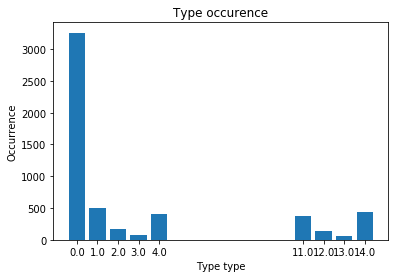

In [7]:
data_hist = np.unique(y_res, return_counts=True)
plt.bar(data_hist[0], data_hist[1])
plt.xticks(data_hist[0], data_hist[0])
plt.xlabel("Type type")
plt.ylabel("Occurrence")
plt.title("Type occurence")
plt.show()

In [8]:
classifier = XGBClassifier(objective='multi:softmax', eval_metric="auc", gamma=0, learning_rate=0.3,
                            max_depth=3, min_child_weight=1, n_estimators=300, nthread=-1,
                            num_class=len(np.unique(y_res)))
classifier.fit(X, y_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, learning_rate=0.3, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=-1, num_class=9, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [9]:
confusion_matrix(y_res, classifier.predict(X))

array([[3258,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  493,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,  169,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,   74,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,  410,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,  381,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,  143,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,   62,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,  436]],
      dtype=int64)

In [10]:
lb = LabelBinarizer()

lb.fit(y_res)

roc_auc_score(lb.transform(y_res), lb.transform(classifier.predict(X)))

1.0

In [11]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for train_index, test_index in skf.split(X, y_res):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_res[train_index], y_res[test_index]
    classifier = XGBClassifier(objective='multi:softmax', eval_metric="auc", gamma=0, learning_rate=0.3,
                            max_depth=3, min_child_weight=1, n_estimators=300, nthread=-1,
                            num_class=len(np.unique(y_res)))
    classifier.fit(X_train, y_train)
    print("--------------------------------------------------")
    print(confusion_matrix(y_test, classifier.predict(X_test)))
    print(roc_auc_score(lb.transform(y_test), lb.transform(classifier.predict(X_test))))

--------------------------------------------------
[[646   2   0   0   1   1   0   0   2]
 [  0  98   0   0   0   1   0   0   0]
 [  1   0  33   0   0   0   0   0   0]
 [  0   0   0  13   0   0   0   2   0]
 [  6   0   0   0  75   0   0   0   1]
 [  1   0   0   0   0  75   0   1   0]
 [  0   0   0   0   0   0  29   0   0]
 [  0   0   0   0   0   0   0  12   1]
 [  5   0   1   0   0   0   2   0  80]]
0.9719123779751809
--------------------------------------------------
[[649   0   0   1   0   0   1   0   1]
 [  1  94   0   0   2   2   0   0   0]
 [  0   0  34   0   0   0   0   0   0]
 [  1   0   0  10   4   0   0   0   0]
 [  3   0   1   0  76   1   0   0   1]
 [  1   1   0   0   0  74   0   0   0]
 [  3   0   0   0   0   1  23   0   2]
 [  1   0   0   0   0   0   0  12   0]
 [  5   0   0   0   2   0   0   0  80]]
0.9496419557830369
--------------------------------------------------
[[647   0   0   0   3   0   0   0   2]
 [  0  95   0   0   0   3   0   0   1]
 [  0   0  32   1   0   0  

In [12]:
from timeblock import TimeBlock
from tram_pred import decode_sound_block, create_output_line, create_test_blocks, filter_blocks

In [13]:
threshold = 0.7

In [14]:
def get_sound_blocks(input_file, classifier, delta=0.6, min_dur=1.5):
    test_sound = create_test_blocks(input_file)
    predict_sound = classifier.predict_proba(test_sound)
    sound_time = deque()
    last_block = None
    for index, final_prediction in enumerate(predict_sound):
        argmax_prob = np.argmax(final_prediction)
        max_prob = final_prediction[argmax_prob]
        if max_prob < threshold:
            continue
        predicted_class = int(classifier.classes_[argmax_prob])
        if predicted_class != 0:
            seconds = index * 0.2
            predicted_class -= 1
            if last_block is None or not last_block.is_within_block(seconds):
                if last_block is not None:
                    sound_time.append(last_block)
                last_block = TimeBlock(seconds, predicted_class, delta=delta)
            else:
                last_block.add_new_time(seconds)
                last_block.add(predicted_class)
    sound_time.append(last_block)
    return filter_blocks(sound_time, min_dur)

def create_predict_file(input_path, classifier):
    sound_blocks = get_sound_blocks(input_path, classifier)
    dec_list = [decode_sound_block(block) for block in sound_blocks] # if block.add_items >= 10]
    lines = [create_output_line(time, decoded) for time, _, decoded in dec_list]
    nl = "\n"
    with open(f"{input_path}.all.csv", "wt") as f:
        f.write(
            f"seconds_offset,accelerating_1_New,accelerating_2_CKD_Long,accelerating_3_CKD_Short,accelerating_4_Old,"
            f"braking_1_New,braking_2_CKD_Long,braking_3_CKD_Short,braking_4_Old{nl}")
        for line in lines:
            f.write(f"{line}{nl}")

def create_output_csv(target_path, classifier):
    for root, _, files in os.walk(target_path):
        for file in files:
            if file.endswith(".wav"):
                create_predict_file(os.path.join(root, file), classifier)

In [15]:
create_output_csv(target_path, classifier)